In [1]:
import optuna

In [1]:

from lightgbm import LGBMRegressor
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import warnings # 実行に関係ない警告を無視
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')

In [4]:
train.head(10)

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
0,1,A,B,A,A,B,D,A,E,C,...,0.881122,0.421650,0.741413,0.895799,0.802461,0.724417,0.701915,0.877618,0.719903,6.994023
1,2,B,A,A,A,B,B,A,E,A,...,0.440011,0.346230,0.278495,0.593413,0.546056,0.613252,0.741289,0.326679,0.808464,8.071256
2,3,A,A,A,C,B,D,A,B,C,...,0.914155,0.369602,0.832564,0.865620,0.825251,0.264104,0.695561,0.869133,0.828352,5.760456
3,4,A,A,A,C,B,D,A,E,G,...,0.934138,0.578930,0.407313,0.868099,0.794402,0.494269,0.698125,0.809799,0.614766,7.806457
4,6,A,B,A,A,B,B,A,E,C,...,0.382600,0.705940,0.325193,0.440967,0.462146,0.724447,0.683073,0.343457,0.297743,6.868974
5,7,A,A,A,C,B,B,A,E,E,...,0.245560,0.217362,0.606298,0.345282,0.351235,0.371940,0.222782,0.279227,0.773600,7.060652
6,8,A,B,A,C,B,D,A,E,G,...,0.931266,0.633157,0.784185,0.912704,0.801154,0.599786,0.901656,0.837474,0.674477,6.165491
7,9,B,A,B,C,B,B,A,E,C,...,0.363130,0.349324,0.252734,0.474170,0.434062,0.729585,0.575455,0.695125,0.224310,8.100110
8,10,A,B,B,A,B,D,A,E,E,...,0.949677,0.532924,0.722310,0.924495,0.812624,0.594173,0.884272,0.816702,0.777538,8.180236
9,11,A,B,A,C,B,D,A,E,E,...,0.825722,0.626083,0.310801,0.944050,0.491695,0.562309,0.555027,0.615598,0.484117,6.589764


In [5]:
#カテゴリ変数と量的変数にわける。

categorical_cols = ['cat' + str(i) for i in range(10)]
continous_cols = ['cont' + str(i) for i in range(14)]

In [6]:
#カテゴリ変数をダミー変数化

for e in categorical_cols:
    le = LabelEncoder()
    #fit_transform()にする
    train[e] = le.fit_transform(train[e])
    test[e] = le.transform(test[e])

In [7]:
#ダミー変数化したデータをdataに格納　
#targetをtargetに格納
data = train[categorical_cols + continous_cols]
target = train['target']

In [8]:
data.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,0,1,0,0,1,3,0,4,2,8,...,0.281421,0.881122,0.421650,0.741413,0.895799,0.802461,0.724417,0.701915,0.877618,0.719903
1,1,0,0,0,1,1,0,4,0,5,...,0.282354,0.440011,0.346230,0.278495,0.593413,0.546056,0.613252,0.741289,0.326679,0.808464
2,0,0,0,2,1,3,0,1,2,13,...,0.293756,0.914155,0.369602,0.832564,0.865620,0.825251,0.264104,0.695561,0.869133,0.828352
3,0,0,0,2,1,3,0,4,6,10,...,0.769785,0.934138,0.578930,0.407313,0.868099,0.794402,0.494269,0.698125,0.809799,0.614766
4,0,1,0,0,1,1,0,4,2,5,...,0.279105,0.382600,0.705940,0.325193,0.440967,0.462146,0.724447,0.683073,0.343457,0.297743


In [9]:
def objective(trial , data=data , target=target):
    #train_test_split
    train_x , test_x , train_y , test_y = train_test_split(data,target,test_size = 0.2 ,random_state = 42)
    #paramater設定 辞書型
             #評価指標の設定
    param = {'metric':'rmse',
             #シード値
             'random_state':48,
             #木の数
             'n_estimators':20000,
             #L1 正則化 大きいと変数を減らす　0.1がデフォ
             'reg_alpha' : trial.suggest_loguniform('reg_alpha',1e-3,10.0),
             #L2 正則化 大きくても変数を減らさない。特徴量が多いときやoverfitする時に大きくする。デフォは0.1
             'reg_lambda' : trial.suggest_loguniform('reg_lambda',1e-3,10.0),
             #木を作成する際に使用する特徴量の数を選択する割合 1　以下の確率　　0.4,0.7がありがち
             'colsample_bytree' : trial.suggest_categorical('colsample_bytree',[0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]),
             #使用するデータの選択割合
             'subsample' : trial.suggest_categorical('subsample',[0.4,0.5,0.6,0.7,0.8,0.9,1.0]),
             #たくさん作った木を足し合わせるときに使う重み係数。精度とトレードオフ。0.00n~0.02?
             #大きいほどひとつひとつの木の予測を多く使う。
             #木の数 n_estimators は少なくなり学習にかかる時間は短くなる。
             'learning_rate': trial.suggest_categorical('learning_rate',[0.006,0.008,0.01,0.014,0.017,0.02]),
             # 各木の最大の深さ 普通 3 ~ 8??? 要確認　
             'max_depth':trial.suggest_categorical('max_depth',[10,20,100]),
             #高すぎると過学習となり、低すぎると未学習
             'num_leaves' : trial.suggest_int('num_leaves',1,1000),
             #末端ノードに含まれる最小のデータ数
             'min_child_samples' : trial.suggest_int('min_child_samples',1,300),
             #データがないカテゴリのノイズを減らす
             'cat_smooth' : trial.suggest_int('min_data_per_groups',1,100)
            }
    # **で辞書型で渡す
    model = LGBMRegressor(**param)
    #train_xとtrain_yでデータと結果を学習（教師）
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=False)
    # test_xで予測
    preds = model.predict(test_x)
    #test_y（本物）で評価
    rmse = mean_squared_error(test_y,preds,squared = False)
    
    return rmse

In [11]:
study = optuna.create_study(direction = 'minimize')
study.optimize(objective,n_trials = 10)
print('Number of finished trials:' , len(study.trials))
print('Best trial',study.best_trial.params)

[I 2021-02-20 21:46:45,310] A new study created in memory with name: no-name-213a79c6-3955-48e5-a3fa-eeb6ac644569
[I 2021-02-20 21:48:21,443] Trial 0 finished with value: 0.8434138999951192 and parameters: {'reg_alpha': 0.08773663064323488, 'reg_lambda': 1.091374014745267, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.008, 'max_depth': 100, 'num_leaves': 219, 'min_child_samples': 184, 'min_data_per_groups': 45}. Best is trial 0 with value: 0.8434138999951192.
[I 2021-02-20 21:49:00,407] Trial 1 finished with value: 0.8437239450606198 and parameters: {'reg_alpha': 7.322650204758263, 'reg_lambda': 0.9184774384347428, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves': 52, 'min_child_samples': 198, 'min_data_per_groups': 75}. Best is trial 0 with value: 0.8434138999951192.
[I 2021-02-20 21:50:38,377] Trial 2 finished with value: 0.8433910311062938 and parameters: {'reg_alpha': 0.0022204640324084233, 'reg_lambda': 0.03936297654

Number of finished trials: 10
Best trial {'reg_alpha': 0.0016230625281907656, 'reg_lambda': 0.02132376944983352, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.008, 'max_depth': 20, 'num_leaves': 459, 'min_child_samples': 222, 'min_data_per_groups': 83}


In [16]:
#実行結果をdataframeで表示。
study.trials_dataframe() 

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_learning_rate,params_max_depth,params_min_child_samples,params_min_data_per_groups,params_num_leaves,params_reg_alpha,params_reg_lambda,params_subsample,state
0,0,0.843414,2021-02-20 21:46:45.315953,2021-02-20 21:48:21.442604,0 days 00:01:36.126651,0.5,0.008,100,184,45,219,0.087737,1.091374,0.6,COMPLETE
1,1,0.843724,2021-02-20 21:48:21.444374,2021-02-20 21:49:00.406405,0 days 00:00:38.962031,0.7,0.017,100,198,75,52,7.322650,0.918477,0.7,COMPLETE
2,2,0.843391,2021-02-20 21:49:00.408125,2021-02-20 21:50:38.376357,0 days 00:01:37.968232,0.4,0.010,10,39,37,634,0.002220,0.039363,0.9,COMPLETE
3,3,0.846614,2021-02-20 21:50:38.378164,2021-02-20 21:51:44.617334,0 days 00:01:06.239170,0.8,0.014,100,189,54,866,0.002483,0.419612,0.9,COMPLETE
4,4,0.844495,2021-02-20 21:51:44.618947,2021-02-20 21:52:41.462239,0 days 00:00:56.843292,0.5,0.014,100,30,71,629,0.147534,0.174463,0.9,COMPLETE
5,5,0.844465,2021-02-20 21:52:41.464071,2021-02-20 21:54:02.761743,0 days 00:01:21.297672,0.9,0.008,10,13,25,121,0.003602,1.991129,0.8,COMPLETE
6,6,0.846063,2021-02-20 21:54:02.763433,2021-02-20 21:54:46.091167,0 days 00:00:43.327734,1.0,0.017,100,285,88,369,0.055061,0.700902,0.5,COMPLETE
7,7,0.844110,2021-02-20 21:54:46.093208,2021-02-20 21:55:22.631877,0 days 00:00:36.538669,0.7,0.017,100,293,44,162,0.005585,2.533302,0.9,COMPLETE
8,8,0.844718,2021-02-20 21:55:22.633915,2021-02-20 21:56:16.824304,0 days 00:00:54.190389,0.5,0.017,100,161,19,889,0.367764,2.062789,0.5,COMPLETE
9,9,0.842727,2021-02-20 21:56:16.825861,2021-02-20 21:57:48.973944,0 days 00:01:32.148083,0.3,0.008,20,222,83,459,0.001623,0.021324,1.0,COMPLETE


In [22]:
#best paramsをパラメーターにする。
params=study.best_params   
params['random_state'] = 48
params['n_estimators'] = 20000 
params['metric'] = 'rmse'

In [23]:
#min_data_per_groupsをcat_smoothと名付けている。
params['cat_smooth'] = params.pop('min_data_per_groups')

In [24]:
params

{'reg_alpha': 0.0016230625281907656,
 'reg_lambda': 0.02132376944983352,
 'colsample_bytree': 0.3,
 'subsample': 1.0,
 'learning_rate': 0.008,
 'max_depth': 20,
 'num_leaves': 459,
 'min_child_samples': 222,
 'random_state': 48,
 'n_estimators': 20000,
 'metric': 'rmse',
 'cat_smooth': 83}

In [25]:
#カラム名だけのlistを出しておく。
columns = categorical_cols+continous_cols
#空のnp行列を用意しとく。
#test.shape (20000,10)だからtest.shape[0] = 20000
preds = np.zeros(test.shape[0])
#5分割して１つをテスト、４つを訓練にする。
kf = KFold(n_splits=5,random_state=48,shuffle=True)
rmse=[]  # list contains rmse for each fold
n=0
#
for trn_idx, test_idx in kf.split(train[columns],train['target']):
    #説明変数（X）を、trainとvalに分ける。
    X_tr,X_val=train[columns].iloc[trn_idx],train[columns].iloc[test_idx]
    #"目的（とする）変数（Y）ではなく"、targetを、trainとvalに分ける。
    y_tr,y_val=train['target'].iloc[trn_idx],train['target'].iloc[test_idx]
    #求めたbest paramでモデルを作る。
    model = LGBMRegressor(**params)
    #X-trainに対してy-train(targetから作った)でテスト。
    #X-val（trainから作った）に対してy-val(trainのtargetから作った)でテスト。（１組目）
    model.fit(X_tr,y_tr,eval_set=[(X_val,y_val)],early_stopping_rounds=100,verbose=False)
    #用意しておいたからのpredsに、testデータを学習させたものK（５）で割る。
    preds+=model.predict(test[columns])/kf.n_splits
    #空のrmse listに、X_valで学習し、y_val(trainのtargetから作った)でテストしたものを
    #１つずつぶち込む。
    rmse.append(mean_squared_error(y_val, model.predict(X_val), squared=False))
    #n=0としておいて、５個分のrmseを出す。
    print(n+1,rmse[n])
    n+=1

1 0.8425915549700728
2 0.8460757861129451
3 0.8437840693532892
4 0.8400520838309983
5 0.8415156286512521


In [27]:
#これらの平均をとる。
np.mean(rmse)

0.8428038245837115

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

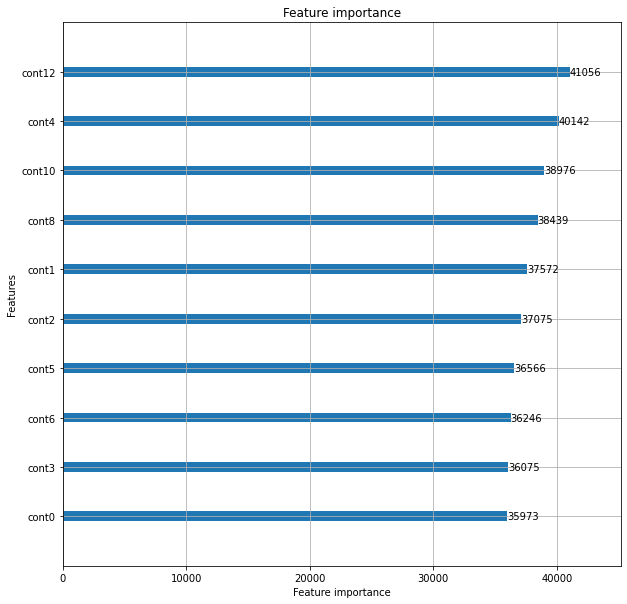

In [30]:
#各特徴量の重要度を算出
from optuna.integration import lightgbm as lgbca
lgb.plot_importance(model, max_num_features=10, figsize=(10,10))

In [31]:
sub['target']=preds
sub.to_csv('submission.csv', index=False)

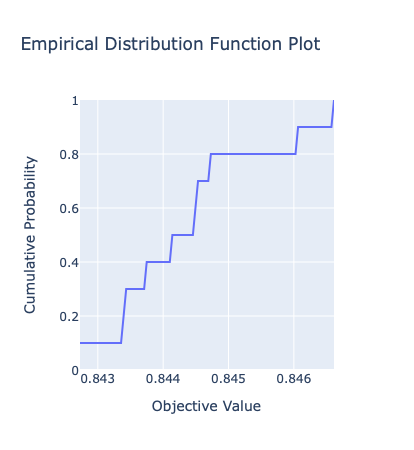

In [48]:
optuna.visualization.plot_edf(study)

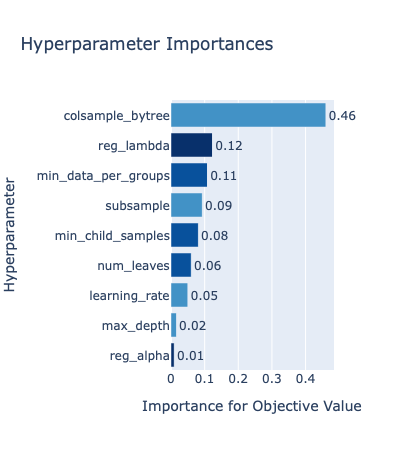

In [49]:
#Visualize parameter importances.
optuna.visualization.plot_param_importances(study)

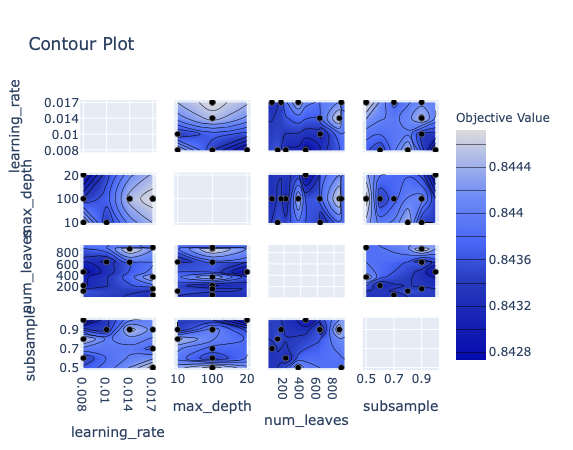

In [50]:
#パラメータの相互作用
#plot_contour: plots parameter interactions on an interactive chart. You can choose which hyperparameters you would like to explore.
optuna.visualization.plot_contour(study, params=['num_leaves',
                            'max_depth',
                            'subsample',
                            'learning_rate',
                            'subsample'])

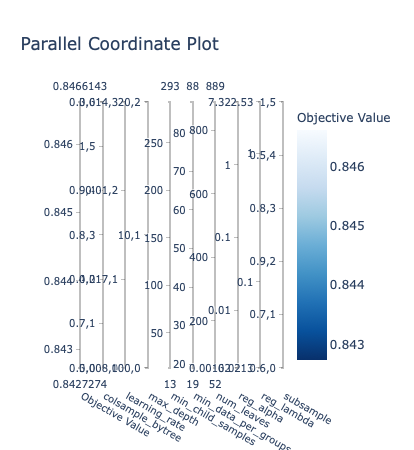

In [52]:
#plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
optuna.visualization.plot_parallel_coordinate(study)

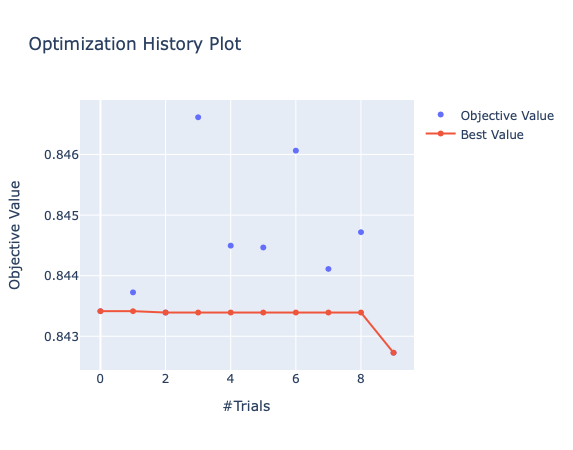

In [53]:
#plot_optimization_histor: shows the scores from all trials as well as the best score so far at each point.
#trialとValueの関係
optuna.visualization.plot_optimization_history(study)